In [1]:
import pandas as pd
ratings = pd.read_csv('data/ratings_small.csv')

In [2]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
ratings.size

400016

In [4]:
# remove unneccessary fields
ratings = ratings.drop('timestamp', 1)

ratings[ratings.isna().any(axis=1)]


,userId,movieId,rating


In [5]:
len(ratings['userId'].unique())

671

In [6]:
len(ratings['movieId'].unique())

9066

In [7]:
# avg number of anime rated per user
import statistics
ratings_per_user = ratings.groupby('userId')['rating'].count()
statistics.mean(ratings_per_user.tolist())

149.03725782414307

Text(0, 0.5, 'Ratings')

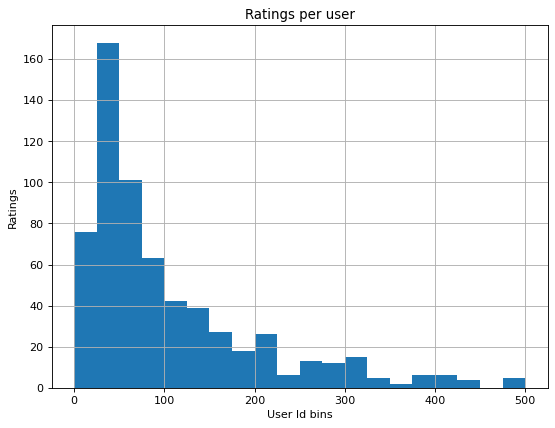

In [8]:
# distribution of ratings per user
# (we may want to exclude users without many data points)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ratings_per_user.hist(bins=20, range=(0,500))
plt.title("Ratings per user")
plt.xlabel("User Id bins")
plt.ylabel("Ratings")

as mean of ratings per user is around 149, let's get users who has rated more than 149 movies

In [9]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)

filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 149]
# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

In [10]:
len(prolific_users)

183

In [11]:
# avg number of ratings given per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
statistics.mean(ratings_per_movie.tolist())

11.030664019413193

Text(0, 0.5, 'Ratings')

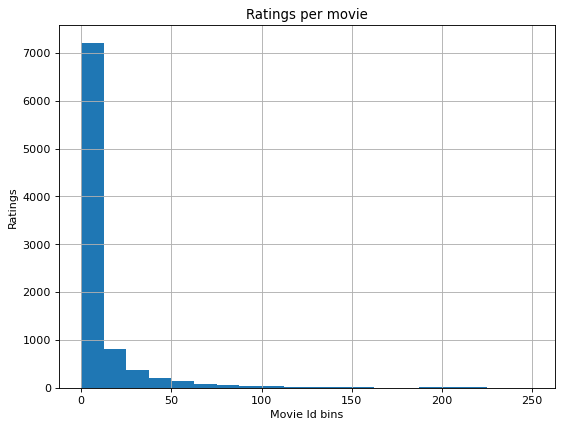

In [12]:
# distribution of ratings per movie

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ratings_per_movie.hist(bins=20, range=(0,250))
plt.title("Ratings per movie")
plt.xlabel("Movie Id bins")
plt.ylabel("Ratings")

as mean of ratings per user is around 11, let's get movies which has been rated more than 11 times

In [13]:
# counts of ratings per anime as a df
ratings_per_movie_df = pd.DataFrame(ratings_per_movie)
filtered_ratings_per_movie_df = ratings_per_movie_df[ratings_per_movie_df.rating >= 11]
# build a list of anime_ids to keep
popular_movies = filtered_ratings_per_movie_df.index.tolist()

In [14]:
len(popular_movies)

2083

filter out movies and users not in those lists.

In [15]:
filtered_ratings = ratings[ratings.movieId.isin(popular_movies)]
filtered_ratings = ratings[ratings.userId.isin(prolific_users)]
len(filtered_ratings)

71195

400016 -> 71195 ratings; 9066 -> 2083 movies; 671 -> 183 users

In [16]:
rating_matrix = filtered_ratings.pivot_table(index='userId', columns='movieId', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
# display the top few rows
rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,2.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def similar_users(user_id, matrix):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    #userIds
    indices = other_users.index.tolist()
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    similarity_mean = statistics.mean(similarities)
    
    similarities_greater_than_mean = []
    similarities_greater_than_mean_indices = []
    
    for i in range(len(similarities)):
        if(similarities[i] > similarity_mean):
            similarities_greater_than_mean.append(similarities[i]) 
            similarities_greater_than_mean_indices.append(indices[i])
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(similarities_greater_than_mean_indices, similarities_greater_than_mean))
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    users = [u[0] for u in index_similarity_sorted]
    
    return users

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def dissimilar_users(user_id, matrix):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    #userIds
    indices = other_users.index.tolist()
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    similarity_mean = statistics.mean(similarities)
    
    similarities_less_than_mean = []
    similarities_less_than_mean_indices = []
    
    for i in range(len(similarities)):
        if(similarities[i] < similarity_mean):
            similarities_less_than_mean.append(similarities[i]) 
            similarities_less_than_mean_indices.append(indices[i])
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(similarities_less_than_mean_indices, similarities_less_than_mean))
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    users = [u[0] for u in index_similarity_sorted]
    
    return users

In [19]:
prolific_users

[4,
 15,
 17,
 19,
 21,
 22,
 23,
 26,
 30,
 34,
 41,
 48,
 56,
 57,
 61,
 72,
 73,
 77,
 78,
 81,
 83,
 86,
 88,
 91,
 93,
 94,
 95,
 99,
 102,
 105,
 111,
 118,
 119,
 125,
 128,
 130,
 133,
 134,
 149,
 150,
 152,
 157,
 165,
 176,
 177,
 185,
 187,
 189,
 195,
 199,
 200,
 205,
 212,
 213,
 214,
 220,
 232,
 235,
 236,
 239,
 240,
 242,
 243,
 247,
 250,
 253,
 262,
 265,
 268,
 270,
 275,
 283,
 285,
 287,
 292,
 294,
 295,
 299,
 303,
 306,
 311,
 312,
 313,
 324,
 328,
 342,
 344,
 345,
 346,
 350,
 353,
 355,
 358,
 363,
 367,
 371,
 373,
 380,
 382,
 384,
 387,
 388,
 390,
 394,
 402,
 405,
 407,
 408,
 412,
 418,
 423,
 426,
 427,
 428,
 430,
 431,
 433,
 434,
 439,
 442,
 452,
 457,
 460,
 461,
 463,
 466,
 468,
 471,
 472,
 475,
 480,
 481,
 487,
 500,
 501,
 505,
 509,
 510,
 514,
 516,
 518,
 519,
 520,
 522,
 529,
 533,
 534,
 537,
 544,
 547,
 553,
 558,
 561,
 562,
 563,
 564,
 574,
 575,
 577,
 580,
 584,
 585,
 587,
 595,
 596,
 597,
 598,
 599,
 605,
 607,
 608,
 61

In [20]:
current_user =  294 # 648 # 
# try it out
similar_user_indices_sample = similar_users(current_user, rating_matrix)
print(len(similar_user_indices_sample))
print(similar_user_indices_sample)

87
[654, 212, 311, 561, 607, 461, 518, 130, 665, 292, 580, 213, 468, 77, 111, 577, 575, 562, 268, 306, 624, 358, 243, 328, 564, 382, 185, 88, 150, 598, 128, 500, 313, 452, 295, 15, 463, 285, 605, 73, 646, 134, 22, 353, 232, 240, 363, 384, 119, 30, 247, 472, 466, 418, 505, 165, 23, 93, 4, 253, 355, 430, 125, 187, 239, 61, 442, 460, 509, 346, 596, 412, 431, 537, 303, 547, 380, 394, 235, 405, 574, 105, 176, 388, 195, 242, 597]


In [21]:
# matrix = rating_matrix
# user_id = 294
# user = matrix[matrix.index == user_id]
# # and a df of all other users
# other_users = matrix[matrix.index != user_id]
# other_users  
# # calc cosine similarity between user and each other user
# similarities = cosine_similarity(user,other_users)[0].tolist()
# indices = other_users.index.tolist()

# similarity_mean = statistics.mean(similarities)
# indices = other_users.index.tolist()
# similarities_less_than_mean = []
# similarities_less_than_mean_indices = []
# for i in range(len(similarities)):
#     if(similarities[i] > similarity_mean):
#     similarities_less_than_mean.append(similarities[i]) 
#     similarities_less_than_mean_indices.append(indices[i])
# print(len(similarities_less_than_mean_indices))
# print(len(similarities_less_than_mean))

# # create key/values pairs of user index and their similarity
# index_similarity = dict(zip(similarities_less_than_mean_indices, similarities_less_than_mean))
# # sort by similarity
# index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
# index_similarity_sorted.reverse()
# users = [u[0] for u in index_similarity_sorted]
# users
# #     # grab k users off the top
# #     top_users_dissimilarities = index_similarity_sorted[:len(similarities_less_than_mean)]
# #     users = [u[0] for u in top_users_dissimilarities]

In [22]:
movies = pd.read_csv('data/preprocessed_movies.csv')

def recommend_item(user_index, similar_user_indices, matrix):
    
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    similar_users = similar_users.mean(axis=0)
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    mean_ratings_mean = statistics.mean(similar_users_df['mean'])
    user_df = matrix[matrix.index == user_index]
    user_df_transposed = user_df.transpose()
    user_df_transposed.columns = ['rating']
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    animes_unseen = user_df_transposed.index.tolist()
    
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    top_n_anime = similar_users_df_ordered.head(7)
    top_n_anime_indices = top_n_anime.index.tolist()
    anime_information = movies[movies['id'].isin(top_n_anime_indices)]
    
    return anime_information #items
# try it out
recommend_item(current_user, similar_user_indices_sample, rating_matrix)

,Unnamed: 0,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,video,vote_average,vote_count,collectionName,genres_names,production_countries_list,production_companies_list,spoken_languages_list
938,938,False,0,NaN,260,tt0026029,en,The 39 Steps,"While on vacation in London, Canadian Richard ...",5.865697,...,Handcuffed to the girl who double-crossed him,The 39 Steps,False,7.4,217.0,NaN,"['Action', 'Thriller', 'Mystery']",['United Kingdom'],"['Gaumont British Picture Corporation', 'The C...",['en']
6388,6388,False,200000000,NaN,296,tt0181852,en,Terminator 3: Rise of the Machines,It's been 10 years since John Connor saved Ear...,20.818907,...,The Machines Will Rise.,Terminator 3: Rise of the Machines,False,5.9,2177.0,The Terminator Collection,"['Action', 'Thriller', 'Science Fiction']","['Germany', 'United Kingdom', 'United States o...","['Columbia Pictures', 'Intermedia Films', 'War...",['en']


In [23]:
dissimilar_user_indices_sample = dissimilar_users(current_user, rating_matrix)
print(len(dissimilar_user_indices_sample))
print(dissimilar_user_indices_sample)

95
[471, 345, 457, 99, 78, 102, 200, 19, 595, 514, 520, 534, 480, 529, 439, 367, 324, 585, 56, 402, 428, 408, 487, 152, 214, 220, 664, 627, 615, 95, 475, 21, 177, 350, 57, 312, 584, 287, 553, 481, 41, 83, 407, 344, 433, 157, 390, 387, 94, 283, 275, 620, 423, 426, 516, 599, 626, 533, 342, 262, 91, 149, 86, 587, 72, 522, 17, 236, 652, 205, 26, 373, 434, 48, 199, 118, 501, 608, 34, 189, 371, 558, 544, 648, 427, 250, 519, 265, 647, 270, 133, 510, 563, 299, 81]


In [24]:
similar_set = set(similar_user_indices_sample)
dissimilar_set = set(dissimilar_user_indices_sample)
common_elements = similar_set.intersection(dissimilar_user_indices_sample)
len(common_elements)

0

In [25]:
#adding new users

In [26]:
user_1_ratings = ratings[ratings.userId == 1]

In [27]:
new_user_df = pd.DataFrame([user_1_ratings['rating'].tolist()], columns=user_1_ratings['movieId'].tolist())

In [28]:
s = new_user_df.xs(0)

s.name = 1
rating_matrix = rating_matrix.append(s)
rating_matrix = rating_matrix.fillna(0)
rating_matrix

,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,2.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
654,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
new_user = 1
# try it out
similar_user_indices_new_user = similar_users(new_user, rating_matrix)
print(len(similar_user_indices_new_user))
print(similar_user_indices_new_user)

76
[195, 130, 102, 119, 387, 575, 468, 510, 232, 214, 73, 19, 34, 585, 518, 363, 564, 605, 580, 472, 4, 509, 461, 452, 654, 463, 265, 23, 533, 95, 587, 41, 373, 346, 405, 529, 607, 57, 118, 105, 380, 577, 30, 311, 534, 15, 624, 285, 306, 547, 21, 358, 423, 77, 212, 646, 185, 505, 514, 312, 303, 466, 561, 647, 294, 133, 608, 665, 22, 457, 390, 537, 56, 150, 430, 283]


In [30]:
#movie data processing

In [31]:
similar_user_indices_sample_ratings = ratings[ratings.userId.isin(similar_user_indices_sample)]
similar_user_indices_sample_ratings

,userId,movieId,rating
147,4,10,4.0
148,4,34,5.0
149,4,112,5.0
150,4,141,5.0
151,4,153,4.0
...,...,...,...
99688,665,5502,4.0
99689,665,5679,3.0
99690,665,5952,5.0
99691,665,5991,4.0


In [32]:
from wordcloud import WordCloud

def plotWordCountsBasedOnColumnValuesAndUsers(user_indices, col_name, movies):
    user_indices_ratings = ratings[ratings.userId.isin(user_indices)]

    user_ratings_per_movie = user_indices_ratings[user_indices_ratings.rating > 4].groupby('movieId')['rating'].count()
    mean = statistics.mean(user_ratings_per_movie.tolist())
    user_ratings_per_movie_df = pd.DataFrame(user_ratings_per_movie)
    filtered_user_ratings_per_movie_df = user_ratings_per_movie_df[user_ratings_per_movie_df.rating > mean]
    movieIds = filtered_user_ratings_per_movie_df.index.tolist()
    len(movieIds)

    sample_movies = movies[movies.id.isin(movieIds)]

    counts = sample_movies[col_name].value_counts()
    counts = counts[counts > statistics.mean(counts)]
    counts = counts[:10]

    wordcloud = WordCloud().generate_from_frequencies(counts)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

C:\Users\Pubudu.C\new\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


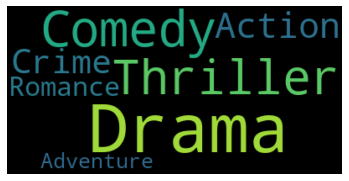

In [33]:
movies = pd.read_csv('data/movies_exploded_genres.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'genres_names', movies)

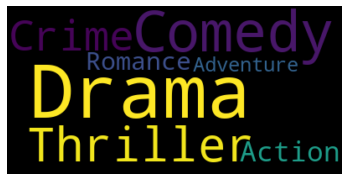

In [34]:
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'genres_names', movies)

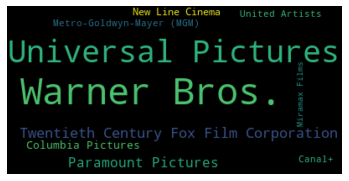

In [35]:
movies = pd.read_csv('data/movies_exploded_production_companies.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'production_companies_list', movies)

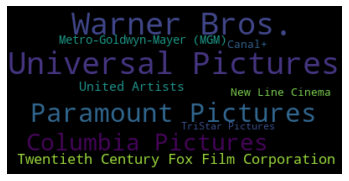

In [36]:
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'production_companies_list', movies)

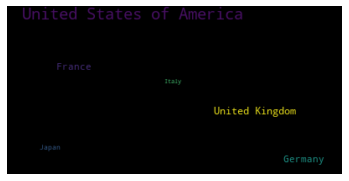

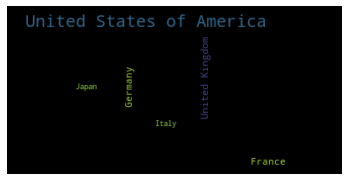

In [37]:
movies = pd.read_csv('data/movies_exploded_production_countries.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'production_countries_list', movies)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'production_countries_list', movies)

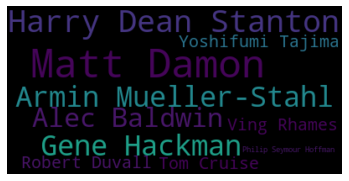

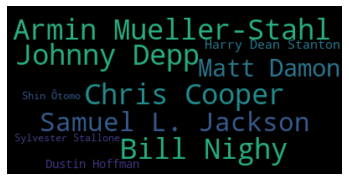

In [38]:
credits = pd.read_csv('data/credits_exploded_actors.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'actors', credits)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'actors', credits)

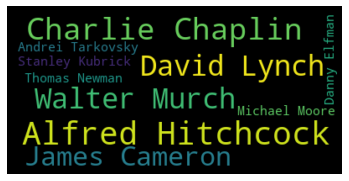

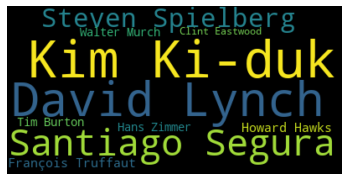

In [39]:
credits = pd.read_csv('data/credits_exploded_crew.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'crew_people', credits)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'crew_people', credits)

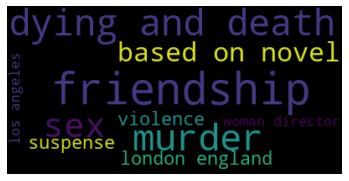

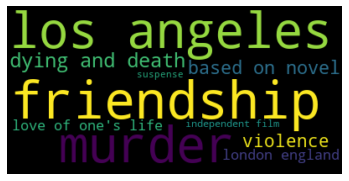

In [40]:
keywords = pd.read_csv('data/keywords_exploded_name.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'keywords_names', keywords)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'keywords_names', keywords)

In [41]:
def getCountsSeries(user_indices, col_name, movies):
    user_indices_ratings = ratings[ratings.userId.isin(user_indices)]

    user_ratings_per_movie = user_indices_ratings[user_indices_ratings.rating > 4].groupby('movieId')['rating'].count()
    mean = statistics.mean(user_ratings_per_movie.tolist())
    user_ratings_per_movie_df = pd.DataFrame(user_ratings_per_movie)
    filtered_user_ratings_per_movie_df = user_ratings_per_movie_df[user_ratings_per_movie_df.rating > mean]
    movieIds = filtered_user_ratings_per_movie_df.index.tolist()

    sample_movies = movies[movies.id.isin(movieIds)]

    counts = sample_movies[col_name].value_counts()
    counts = counts[counts > statistics.mean(counts)]
    return counts

In [42]:
getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)

friendship         21
dying and death    15
murder             15
sex                13
based on novel     12
                   ..
mutant              2
sexual identity     2
illness             2
shipwreck           2
exotic island       2
Name: keywords_names, Length: 467, dtype: int64

In [43]:
getCountsSeries(dissimilar_user_indices_sample, 'keywords_names', keywords)

friendship            18
murder                16
los angeles           16
dying and death       16
based on novel        15
                      ..
madness                2
san francisco          2
outer space            2
witness protection     2
loss of son            2
Name: keywords_names, Length: 491, dtype: int64

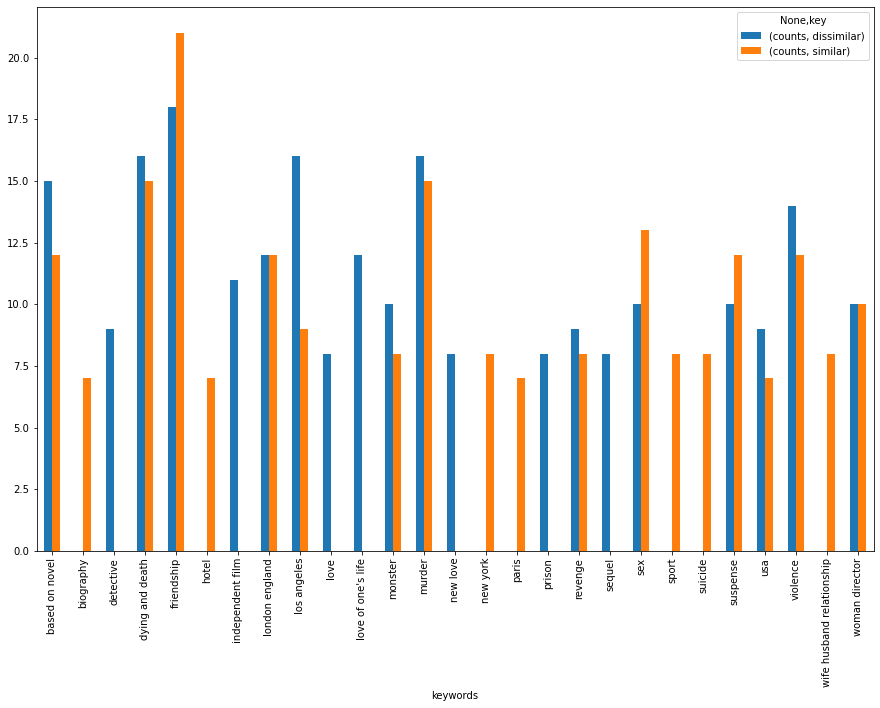

In [44]:
similar_user_df = getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['keywords','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))

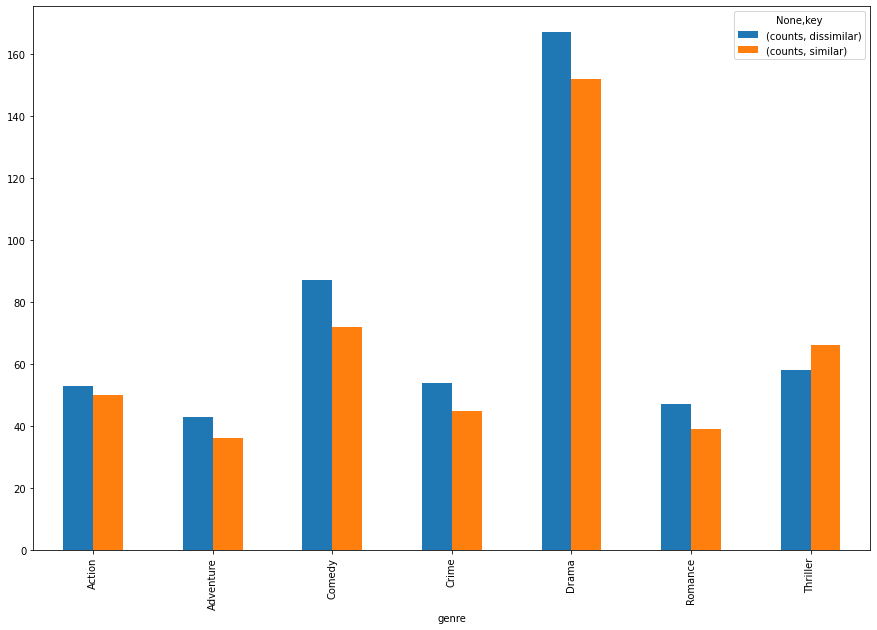

In [45]:
movies = pd.read_csv('data/movies_exploded_genres.csv')

similar_user_df = getCountsSeries(similar_user_indices_sample, 'genres_names', movies).rename_axis('genre').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_indices_sample, 'genres_names', movies).rename_axis('genre').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['genre','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))

In [46]:
# getCountsSeries(similar_user_indices_sample, 'genres_names', movies)

In [47]:
# randomly pick dissimilar user 270 let's see his similar group and their preferences
dissimilar_user_similar_group = similar_users(236, rating_matrix)
print(len(dissimilar_user_similar_group))
print(dissimilar_user_similar_group)

78
[23, 587, 585, 468, 505, 17, 472, 102, 19, 265, 608, 481, 597, 195, 21, 537, 547, 509, 387, 345, 118, 15, 243, 580, 529, 423, 268, 81, 232, 119, 358, 514, 520, 452, 355, 431, 99, 596, 34, 242, 240, 342, 214, 388, 575, 647, 262, 152, 428, 30, 130, 311, 105, 434, 125, 562, 564, 4, 461, 466, 544, 295, 134, 433, 77, 430, 558, 577, 519, 344, 394, 471, 463, 220, 56, 561, 22, 442]


C:\Users\Pubudu.C\new\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


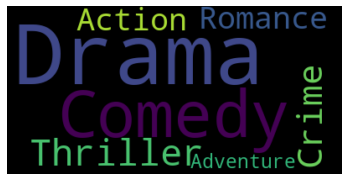

In [48]:
movies = pd.read_csv('data/movies_exploded_genres.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'genres_names', movies)

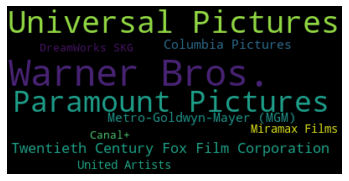

In [49]:
movies = pd.read_csv('data/movies_exploded_production_companies.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'production_companies_list', movies)

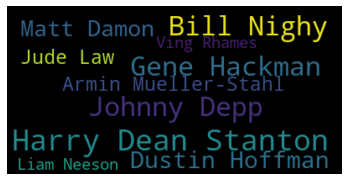

In [50]:
credits = pd.read_csv('data/credits_exploded_actors.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'actors', credits)

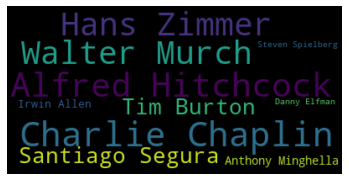

In [51]:
credits = pd.read_csv('data/credits_exploded_crew.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'crew_people', credits)

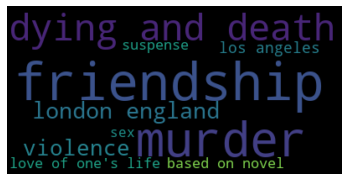

In [52]:
keywords = pd.read_csv('data/keywords_exploded_name.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'keywords_names', keywords)

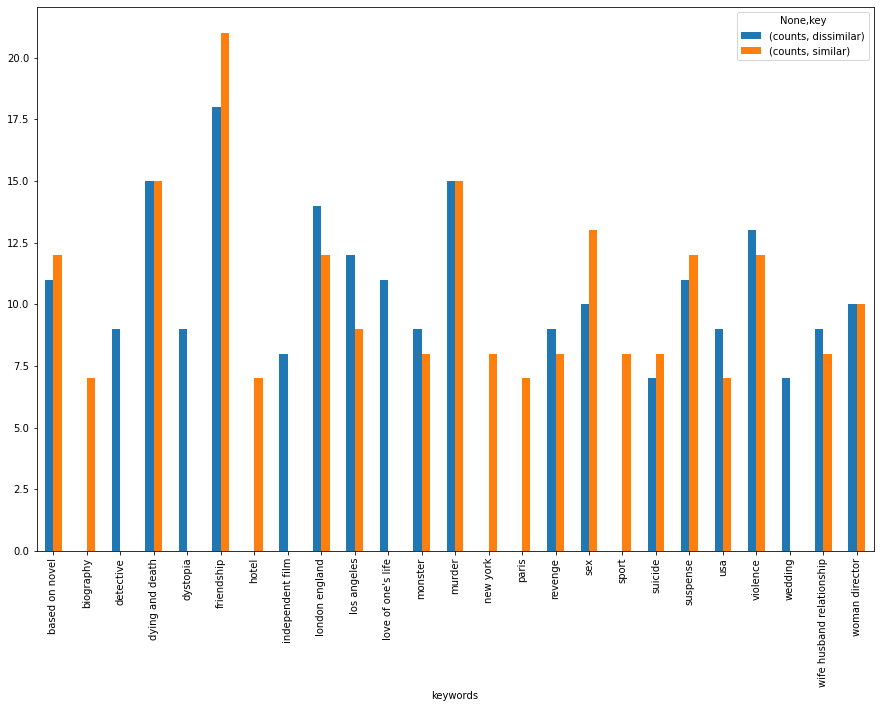

In [53]:
similar_user_df = getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_similar_group, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['keywords','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))